In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set_style('whitegrid')


from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline


/tmp/ipykernel_26236/4125469611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = (df['poss'] >= 500).astype(int)
/tmp/ipykernel_26236/4125469611.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = df['significant_poss'].astype('category')


<AxesSubplot:xlabel='mp', ylabel='war_total'>

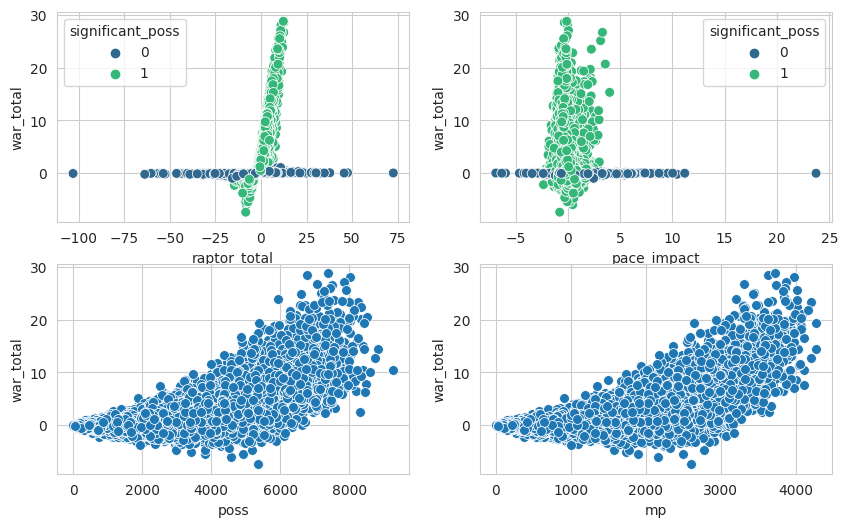

In [3]:
df_player = pd.read_csv('data/historical_RAPTOR_by_player.csv')
# I'll just keep war_total, raptor_total, pace impact. Also mp and poss
df = df_player[['player_name',	'player_id','poss',	'mp',	'raptor_total',	'war_total',	'pace_impact']]
# I will 'clusterize' by hand, dividing the data in two groups: less and more than 500 poss
df['significant_poss'] = (df['poss'] >= 500).astype(int)
# Convert 'significant_poss' to categorical type
df['significant_poss'] = df['significant_poss'].astype('category')
# replacing nan value in pace_impact col
df.at[12254, 'pace_impact'] = 0

f,axs = plt.subplots(ncols = 2 , nrows =2 , figsize=(10, 6))
axs = axs.flatten()
sns.scatterplot(x='raptor_total', y='war_total', hue='significant_poss', palette='viridis', data=df, s=50, ax = axs[0])
sns.scatterplot(x='pace_impact' , y='war_total',hue='significant_poss', palette='viridis', data=df, s=50, ax = axs[1])
sns.scatterplot(x='poss', y='war_total',  palette='viridis', data=df, s=50, ax = axs[2])
sns.scatterplot(x='mp' , y='war_total', palette='viridis', data=df, s=50, ax = axs[3])

In [6]:
# Split the data into low possession and high possession based on your column 'significant_poss'
low_poss_df = df[df['significant_poss'] == 0]
high_poss_df = df[df['significant_poss'] == 1]

# Features (X) and target (y) for low possession
X_low = low_poss_df[[ 'raptor_total']]  # Example features
y_low = low_poss_df['war_total']  # Example target variable

# Features (X) and target (y) for high possession
X_high = high_poss_df[[ 'raptor_total']]  # Example features
y_high = high_poss_df['war_total']  # Example target variable

# Features (X) and target (y) for high possession
X_full = df[[ 'raptor_total']]  # Example features
y_full = df['war_total']  # Example target variable

In [8]:
# we'll see how well a linear model goes with raptor_total vs war_total relationship, for high and low posession,
# or without discriminating posession
# Initialize the linear regression model
linear_model = LinearRegression()
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
svr_model = SVR(kernel='rbf')

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name, cv = 5 , n_jobs= 4):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs= n_jobs)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results



# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}



for model , model_name in zip([ poly_model, svr_model, linear_model], [ 'poly_model', 'svr_model', 'linear_model']):
    for X,y,data_type  in zip([X_low,X_high],[y_low,y_high],['low','high']):
        cross_validate_model(model, X, y, f"{data_type} {model_name}")


low poly_model Cross-validation RMSE Scores: [-0.18245168 -0.16590802 -0.19129138 -0.424227   -0.18043893]
low poly_model Mean RMSE Score: -0.2288634021609759
low poly_model Cross-validation R² Scores: [ 0.30275905  0.29197757  0.29661827 -3.01951402  0.28463857]
low poly_model Mean R² Score: -0.36870411161189187

high poly_model Cross-validation RMSE Scores: [-1.31335118 -1.30787576 -1.41581972 -1.33485594 -1.21094363]
high poly_model Mean RMSE Score: -1.3165692486501157
high poly_model Cross-validation R² Scores: [0.85672197 0.87754305 0.877338   0.87463096 0.86403435]
high poly_model Mean R² Score: 0.870053665270459

low svr_model Cross-validation RMSE Scores: [-0.21815189 -0.19742635 -0.2284084  -0.21371036 -0.21337926]
low svr_model Mean RMSE Score: -0.214215251947454
low svr_model Cross-validation R² Scores: [ 0.00320676 -0.00258795 -0.00282337 -0.02006552 -0.00039032]
low svr_model Mean R² Score: -0.004532082047838259

high svr_model Cross-validation RMSE Scores: [-3.8586912  -4

In [25]:


# Split the data into train and test for low possession
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=0.2, random_state=42)

# Split the data into train and test for high possession
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)

# Split the full data into train and test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)



# Initialize models
linear_model1 = LinearRegression()
linear_model2 = LinearRegression()
linear_model3 = LinearRegression()

poly_model1 = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model2 = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())

svr_model1 = SVR(kernel='rbf')
svr_model2 = SVR(kernel='rbf')
svr_model3 = SVR(kernel='rbf')

# Train and predict for each model on low possession data
linear_model1.fit(X_low_train, y_low_train)
y_low_pred_linear = linear_model1.predict(X_low_test)

poly_model1.fit(X_low_train, y_low_train)
y_low_pred_poly = poly_model1.predict(X_low_test)

svr_model1.fit(X_low_train, y_low_train)
y_low_pred_svr = svr_model1.predict(X_low_test)

# Train and predict for each model on high possession data
linear_model2.fit(X_high_train, y_high_train)
y_high_pred_linear = linear_model2.predict(X_high_test)

poly_model2.fit(X_high_train, y_high_train)
y_high_pred_poly = poly_model2.predict(X_high_test)

svr_model2.fit(X_high_train, y_high_train)
y_high_pred_svr = svr_model2.predict(X_high_test)

# Train and predict for each model on full data
linear_model3.fit(X_full_train, y_full_train)
y_full_pred_linear = linear_model3.predict(X_full_test)

poly_model3.fit(X_full_train, y_full_train)
y_full_pred_poly = poly_model3.predict(X_full_test)

svr_model3.fit(X_full_train, y_full_train)
y_full_pred_svr = svr_model3.predict(X_full_test)


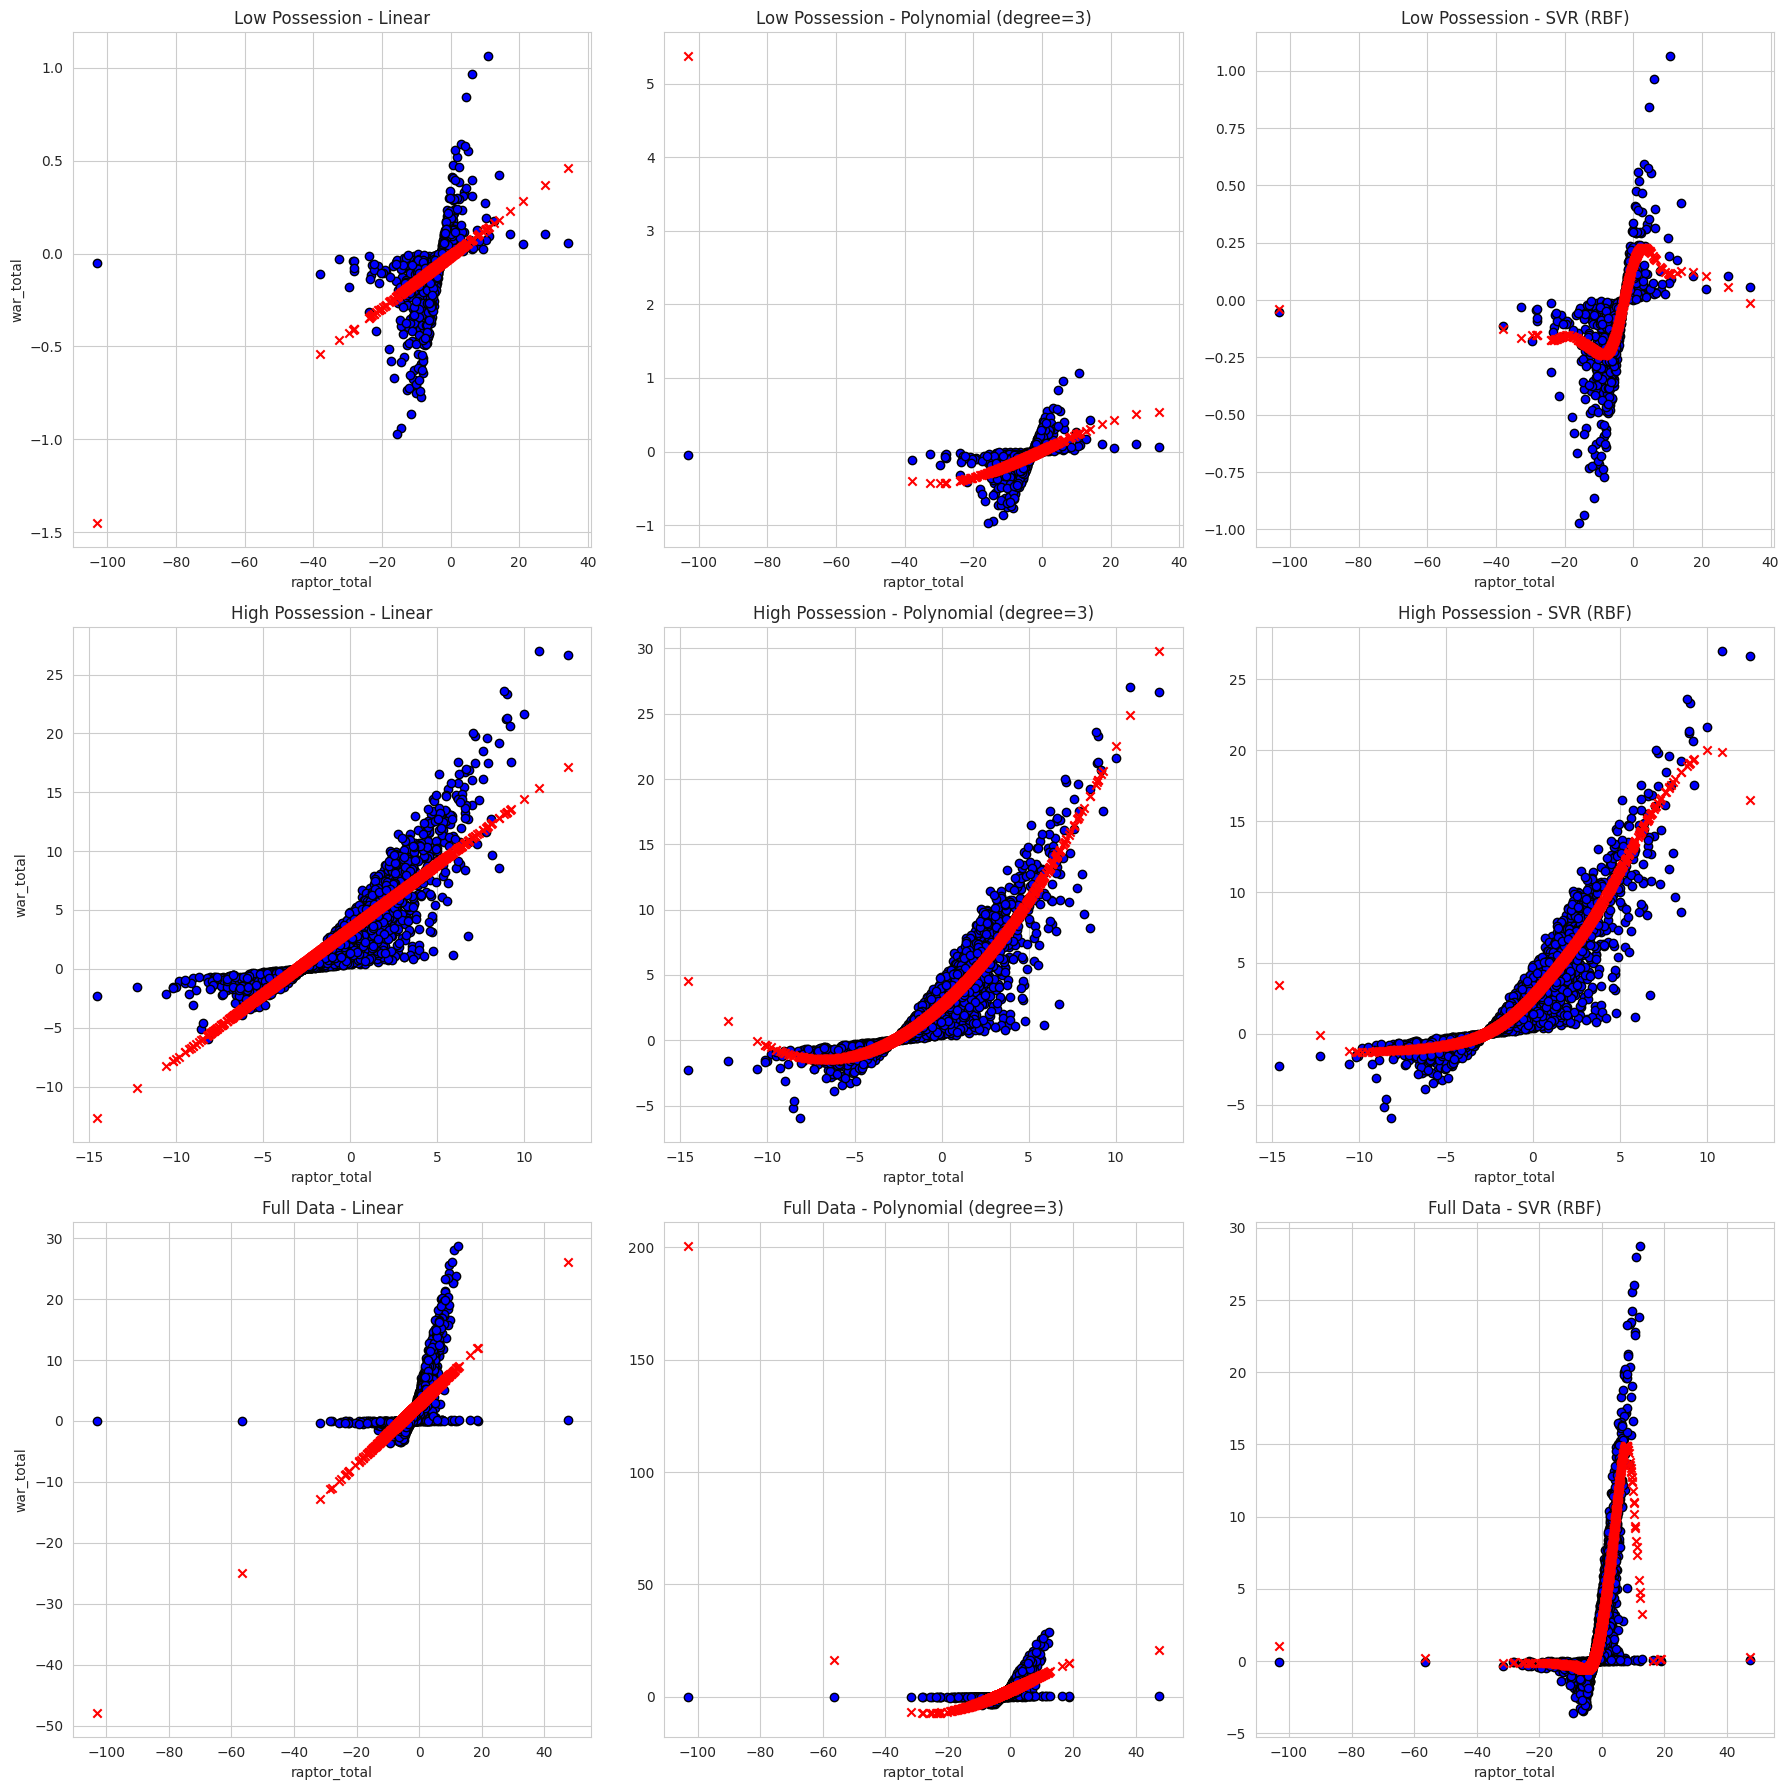

In [26]:
# Plotting the results
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

# Plot for low possession
axs[0, 0].scatter(X_low_test, y_low_test, color='blue', edgecolor='k', label='True Data')
axs[0, 0].scatter(X_low_test, y_low_pred_linear, color='red', label='Predicted', marker='x')
axs[0, 0].set_title('Low Possession - Linear')
axs[0, 0].set_xlabel('raptor_total')
axs[0, 0].set_ylabel('war_total')

axs[0, 1].scatter(X_low_test, y_low_test, color='blue', edgecolor='k', label='True Data')
axs[0, 1].scatter(X_low_test, y_low_pred_poly, color='red', label='Predicted', marker='x')
axs[0, 1].set_title('Low Possession - Polynomial (degree=3)')
axs[0, 1].set_xlabel('raptor_total')

axs[0, 2].scatter(X_low_test, y_low_test, color='blue', edgecolor='k', label='True Data')
axs[0, 2].scatter(X_low_test, y_low_pred_svr, color='red', label='Predicted', marker='x')
axs[0, 2].set_title('Low Possession - SVR (RBF)')
axs[0, 2].set_xlabel('raptor_total')

# Plot for high possession
axs[1, 0].scatter(X_high_test, y_high_test, color='blue', edgecolor='k', label='True Data')
axs[1, 0].scatter(X_high_test, y_high_pred_linear, color='red', label='Predicted', marker='x')
axs[1, 0].set_title('High Possession - Linear')
axs[1, 0].set_xlabel('raptor_total')
axs[1, 0].set_ylabel('war_total')

axs[1, 1].scatter(X_high_test, y_high_test, color='blue', edgecolor='k', label='True Data')
axs[1, 1].scatter(X_high_test, y_high_pred_poly, color='red', label='Predicted', marker='x')
axs[1, 1].set_title('High Possession - Polynomial (degree=3)')
axs[1, 1].set_xlabel('raptor_total')

axs[1, 2].scatter(X_high_test, y_high_test, color='blue', edgecolor='k', label='True Data')
axs[1, 2].scatter(X_high_test, y_high_pred_svr, color='red', label='Predicted', marker='x')
axs[1, 2].set_title('High Possession - SVR (RBF)')
axs[1, 2].set_xlabel('raptor_total')

# Plot for full data
axs[2, 0].scatter(X_full_test, y_full_test, color='blue', edgecolor='k', label='True Data')
axs[2, 0].scatter(X_full_test, y_full_pred_linear, color='red', label='Predicted', marker='x')
axs[2, 0].set_title('Full Data - Linear')
axs[2, 0].set_xlabel('raptor_total')
axs[2, 0].set_ylabel('war_total')

axs[2, 1].scatter(X_full_test, y_full_test, color='blue', edgecolor='k', label='True Data')
axs[2, 1].scatter(X_full_test, y_full_pred_poly, color='red', label='Predicted', marker='x')
axs[2, 1].set_title('Full Data - Polynomial (degree=3)')
axs[2, 1].set_xlabel('raptor_total')

axs[2, 2].scatter(X_full_test, y_full_test, color='blue', edgecolor='k', label='True Data')
axs[2, 2].scatter(X_full_test, y_full_pred_svr, color='red', label='Predicted', marker='x')
axs[2, 2].set_title('Full Data - SVR (RBF)')
axs[2, 2].set_xlabel('raptor_total')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


I am going to go with polynomial model for the high poss data, and with SVR for low poss data. 
I'll try this out for war_total against pace_impact

In [43]:
# Split the data into low possession and high possession based on your column 'significant_poss'
low_poss_df = df[df['significant_poss'] == 0]
high_poss_df = df[df['significant_poss'] == 1]

# Features (X) and target (y) for low possession
X_low = low_poss_df[[ 'pace_impact']]  # Example features
y_low = low_poss_df['war_total']  # Example target variable

# Features (X) and target (y) for high possession
X_high = high_poss_df[[ 'pace_impact']]  # Example features
y_high = high_poss_df['war_total']  # Example target variable

# Features (X) and target (y) for high possession
X_full = df[[ 'pace_impact']]  # Example features
y_full = df['war_total']  # Example target variablepace_impact

# we'll see how well a linear model goes with raptor_total vs war_total relationship, for high and low posession,
# or without discriminating posession
# Initialize the linear regression model
linear_model = LinearRegression()
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
svr_model = SVR(kernel='rbf')

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name):
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results



# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}



for model , model_name in zip([linear_model, poly_model, svr_model], ['linear_model', 'poly_model', 'svr_model']):
    for X,y,data_type  in zip([X_low,X_high,X_full],[y_low,y_high,y_full],['low','high','full']):
        cross_validate_model(model, X, y, f"{data_type} {model_name}")


low linear_model Cross-validation RMSE Scores: [-0.21842502 -0.19784503 -0.22752815 -0.21238028 -0.21346414]
low linear_model Mean RMSE Score: -0.2139285229552109
low linear_model Cross-validation R² Scores: [ 0.00070918 -0.00684484  0.00489124 -0.00740779 -0.00118634]
low linear_model Mean R² Score: -0.0019677084681302805

high linear_model Cross-validation RMSE Scores: [-3.38060067 -3.73425542 -3.92410618 -3.6245765  -3.21882785]
high linear_model Mean RMSE Score: -3.576473324421104
high linear_model Cross-validation R² Scores: [0.05069534 0.00170593 0.0577294  0.07565088 0.03932418]
high linear_model Mean R² Score: 0.045021147781332926

full linear_model Cross-validation RMSE Scores: [-3.20711778 -3.50038768 -3.74327238 -3.4737165  -3.03594112]
full linear_model Mean RMSE Score: -3.3920870921548456
full linear_model Cross-validation R² Scores: [0.04643375 0.02079257 0.04633845 0.05244868 0.03119406]
full linear_model Mean R² Score: 0.03944150105481485

low poly_model Cross-validatio

In [44]:
# Split the data into train and test for low possession
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=0.2, random_state=42)

# Split the data into train and test for high possession
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)

# Split the full data into train and test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)



# Initialize models
linear_model1 = LinearRegression()
linear_model2 = LinearRegression()
linear_model3 = LinearRegression()

poly_model1 = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model2 = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())

svr_model1 = SVR(kernel='rbf')
svr_model2 = SVR(kernel='rbf')
svr_model3 = SVR(kernel='rbf')

# Train and predict for each model on low possession data
linear_model1.fit(X_low_train, y_low_train)
y_low_pred_linear = linear_model1.predict(X_low_test)

poly_model1.fit(X_low_train, y_low_train)
y_low_pred_poly = poly_model1.predict(X_low_test)

svr_model1.fit(X_low_train, y_low_train)
y_low_pred_svr = svr_model1.predict(X_low_test)

# Train and predict for each model on high possession data
linear_model2.fit(X_high_train, y_high_train)
y_high_pred_linear = linear_model2.predict(X_high_test)

poly_model2.fit(X_high_train, y_high_train)
y_high_pred_poly = poly_model2.predict(X_high_test)

svr_model2.fit(X_high_train, y_high_train)
y_high_pred_svr = svr_model2.predict(X_high_test)

# Train and predict for each model on full data
linear_model3.fit(X_full_train, y_full_train)
y_full_pred_linear = linear_model3.predict(X_full_test)

poly_model3.fit(X_full_train, y_full_train)
y_full_pred_poly = poly_model3.predict(X_full_test)

svr_model3.fit(X_full_train, y_full_train)
y_full_pred_svr = svr_model3.predict(X_full_test)